In [1]:
import cv2
import glob
import numpy as np
print("OpenCV version :  {0}".format(cv2.__version__))

OpenCV version :  4.2.0


# Step 1 Load the images and camera parameters.

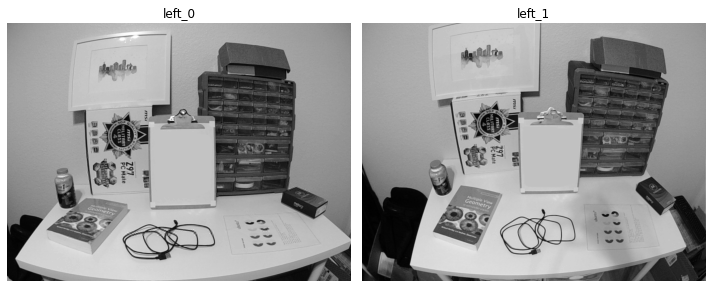

In [2]:
# 0 for grayscale
left_ = [cv2.imread(image, 0) for image in sorted(glob.glob("../../images/task_7/left_*.png"))]
right_ = [cv2.imread(image, 0) for image in sorted(glob.glob("../../images/task_7/right_*.png"))]

import matplotlib.pyplot as plt
def plot_figures(figures, nrows=1, ncols=1):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10,10))
    if(nrows > 1 or ncols > 1):
        for ind,title in enumerate(figures):
            axeslist.ravel()[ind].imshow(figures[title], cmap=plt.gray())
            axeslist.ravel()[ind].set_title(title)
            axeslist.ravel()[ind].set_axis_off()
        plt.tight_layout() # optional
    else:
        for ind,title in enumerate(figures):
            axeslist.imshow(figures[title], cmap=plt.gray())
            axeslist.set_title(title)
            axeslist.set_axis_off()
            

plot_figures({'left_0': left_[0], 'left_1': left_[1]}, 1, 2)

## Camera parameter matrices

In [3]:
left_intrinsic = np.array([[423.27381306, 0, 341.34626532],
                           [0, 421.27401756, 269.28542111],
                           [0, 0, 1]])

right_intrinsic = np.array([[420.91160482, 0, 352.16135589],
                            [0, 418.72245958, 264.50726699],
                            [0, 0, 1]])

distCoeffs_left = np.array([-0.43394157423038077, 0.26707717557547866,
                             -0.00031144347020293427, 0.0005638938101488364,
                             -0.10970452266148858])
distCoeffs_right = np.array([-0.4145817681176909, 0.19961273246897668,
                             -0.00014832091141656534, -0.0013686760437966467,
                             -0.05113584625015141])

# Step 2 Detect, match, and associate features on the image pair.

## First, undistort the images

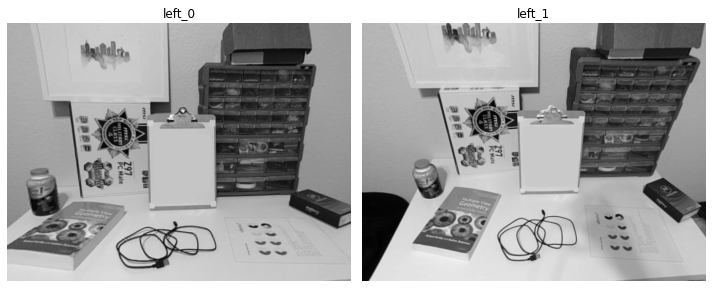

In [4]:
def undistortImage(img, mtx, distCoeffs):
    h,  w = img.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx,distCoeffs,(w,h),0,(w,h))   # warp=0

#     dst = cv2.undistort(img, mtx, distCoeffs, None, newcameramtx)

    mapx, mapy = cv2.initUndistortRectifyMap(left_intrinsic, distCoeffs_left, None, newcameramtx, (w,h), 5)
    dst = cv2.remap(img, mapx, mapy, cv2.INTER_LINEAR)

    # crop the image
    x,y,w,h = roi
    return dst[y:y+h, x:x+w]

for i in range(len(left_)):
    left_[i] = undistortImage(left_[i], left_intrinsic, distCoeffs_left)

for i in range(len(right_)):
    right_[i] = undistortImage(right_[i], right_intrinsic, distCoeffs_right)
    
plot_figures({'left_0': left_[0], 'left_1': left_[1]}, 1, 2)

## Get ORB features

In [5]:
left_0 = left_[0].copy()
left_1 = left_[1].copy()

# Initiate STAR detector
orb = cv2.ORB_create()

# find the keypoints with ORB
kp_0 = orb.detect(left_0,None)
kp_1 = orb.detect(left_1,None)

# compute the descriptors with ORB
kp_0, des_0 = orb.compute(left_0, kp_0)
kp_1, des_1 = orb.compute(left_1, kp_1)

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(des_0,des_1)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

print(len(matches))

210


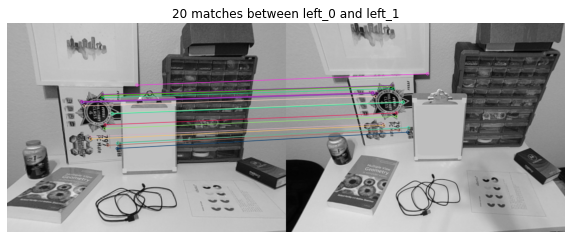

In [6]:
img = cv2.drawMatches(left_0,kp_0,left_1,kp_1,matches[:20], None,flags=2)

plot_figures({'20 matches between left_0 and left_1':img})

# Step 3 Calculate the essential matrix between the image pair.

## Attempt 1

In [7]:
# select points to evaluate the fundamental matrix
pts1 = []
pts2 = []

# get the 20 best points
for match in matches[:18]:
    pts1.append(kp_0[match.queryIdx].pt)
    pts2.append(kp_1[match.trainIdx].pt)

pts1 = np.array(pts1)
pts2 = np.array(pts2)

# creating homegeneous coordenate
# pones = np.ones((1, len(pts1))).T

# pth_1 = np.hstack((pts1, pones))
# pth_2 = np.hstack((pts2, pones))

In [8]:
cv2.findEssentialMat?

In [9]:
# evaluate the essential Matrix (using the original points, not the normilized ones)
E, mask0 = cv2.findEssentialMat(pts1, pts2, left_intrinsic)    # pass in the camera matrix since we undistorted the images

# evaluate the fundamental matrix (using the normilized points)
# F, mask = cv2.findFundamentalMat(pts1, pts2)

E = np.mat(E)
# F = np.mat(F)
print(E)

[[ 0.04019135 -0.04537563 -0.70439824]
 [-0.27580074  0.01417297 -0.02791289]
 [ 0.6485929  -0.03523552  0.03447442]]


In [10]:
for i in mask0:
    if not i[0]:   # if i is 0
        print(i)

no output means all the points are inliers :)

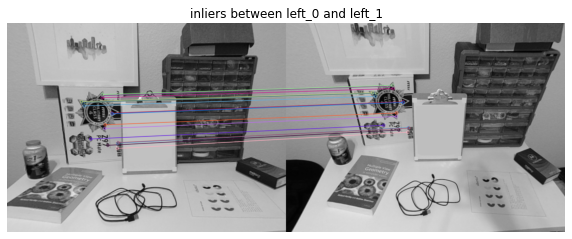

In [12]:
img = cv2.drawMatches(left_0,kp_0,left_1,kp_1,matches[:18], None,flags=2)

plot_figures({'inliers between left_0 and left_1':img})

### I don't think the rest of this is needed

In [13]:
def drawlines(img1, img2, lines, pts1, pts2):
    """ img1 - image on which we draw the epilines for the points in img2
    lines - corresponding epilines """
    r, c = img1.shape
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1]])
        x1, y1 = map(int, [c, -(r[2] + r[0] * c) / r[1]])
        img1 = cv2.line(img1, (x0, y0), (x1, y1), color, 1)
    return img1, img2

In [14]:
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img_left, img_right, lines1, pts1, pts2)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(img_right, img_left, lines2, pts2, pts1)
plot_figures({'left':img5, 'right': img3}, 1, 2)

NameError: name 'img_left' is not defined

## Attempt 2

In [ ]:
#extract float coordinates for keypoints
pts_left = np.array([kp_left[i].pt for i in range (len(kp_left))])
pts_right = np.array([kp_right[i].pt for i in range (len(kp_right))])

Emat, Emask = cv2.findEssentialMat(pts_left, pts_right)
Fmat, Fmask = cv2.findFundamentalMat(pts_left, pts_right)

print(Emat)
print(Fmat)

In [ ]:
# select inliner points
mask_pts_left = pts_left[Emask.ravel() == 1]
mask_pts_right = pts_right[Emask.ravel() == 1]

In [ ]:
def drawlines(img1, img2, lines, pts1, pts2):
    """ img1 - image on which we draw the epilines for the points in img2
    lines - corresponding epilines """
    r, c = img1.shape
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1]])
        x1, y1 = map(int, [c, -(r[2] + r[0] * c) / r[1]])
        img1 = cv2.line(img1, (x0, y0), (x1, y1), color, 1)
    return img1, img2

In [ ]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(mask_pts_right.reshape(-1, 1, 2), 2, Fmat)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img_left, img_right, lines1, mask_pts_left, mask_pts_right)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(mask_pts_left.reshape(-1, 1, 2), 1, Fmat)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(img_right, img_left, lines2, mask_pts_right, mask_pts_left)
plot_figures({'left':img5, 'right': img3}, 1, 2)

# Step 4: Determine relative camera pose

In [ ]:
cv2.recoverPose?

In [13]:
number_of_inlier_pts, R, t, mask = cv2.recoverPose(E,pts1,pts2,left_intrinsic)
number_of_inlier_pts, R, t, mask

(18,
 array([[ 0.99559479, -0.07088327,  0.06137249],
        [ 0.09088359,  0.89048119, -0.44585135],
        [-0.02304765,  0.44946503,  0.89300056]]),
 array([[-0.01725258],
        [ 0.91973251],
        [ 0.39216636]]),
 array([[255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255]], dtype=uint8))

# Step 5: Check the reconstruction results
Use the overloaded function [recoverPose](https://docs.opencv.org/4.2.0/d9/d0c/group__calib3d.html#ga2ee9f187170acece29c5172c2175e7ae)

In [14]:
distanceThresh = 20
number_of_inlier_pts, R, t, mask, triangulatedPoints = cv2.recoverPose(E,pts1,pts2,left_intrinsic,distanceThresh,R,t,mask)

In [15]:
triangulatedPoints

array([[ 0.33607971,  0.23617063,  0.32403475,  0.24541488,  0.24805911,
         0.33793567,  0.18955405,  0.18711897,  0.21301053,  0.25316374,
         0.25403642,  0.21281311,  0.25368418,  0.25253922,  0.34006347,
         0.33144959,  0.30898789,  0.19208574],
       [ 0.17459238, -0.02453931,  0.17346261,  0.07444087,  0.05672997,
         0.17379228, -0.01401657, -0.0116595 ,  0.13102149,  0.19970521,
         0.20965977,  0.12802045,  0.20870428,  0.21361815,  0.17606016,
         0.15818369,  0.00597882, -0.0403165 ],
       [-0.84416701, -0.89576672, -0.84855424, -0.88869309, -0.88888349,
        -0.84350509, -0.90795472, -0.90696553, -0.89132965, -0.8658023 ,
        -0.86402231, -0.89174102, -0.86495288, -0.86309838, -0.84201881,
        -0.84915524, -0.87292094, -0.90689448],
       [-0.37940741, -0.3757968 , -0.38061517, -0.38007194, -0.38096526,
        -0.37959831, -0.37348497, -0.37717911, -0.37814195, -0.38263863,
        -0.38075414, -0.37831112, -0.37939871, -0.381

In [22]:
# convert to cartesian coordinates
points3D = []
points3D.append(triangulatedPoints[0]/triangulatedPoints[3])
points3D.append(triangulatedPoints[1]/triangulatedPoints[3])
points3D.append(triangulatedPoints[2]/triangulatedPoints[3])
points3D = np.array(points3D)
points3D

array([[-0.88580164, -0.62845302, -0.8513448 , -0.6457064 , -0.65113314,
        -0.89024546, -0.50752791, -0.49610109, -0.56330839, -0.6616262 ,
        -0.6671928 , -0.56253466, -0.66864799, -0.6617135 , -0.8950155 ,
        -0.87328122, -0.81852954, -0.51517693],
       [-0.46017123,  0.06529942, -0.45574276, -0.19585995, -0.14891114,
        -0.45783207,  0.03752915,  0.03091236, -0.34648758, -0.52191596,
        -0.55064345, -0.33839993, -0.55009223, -0.55973093, -0.463374  ,
        -0.41677182, -0.0158383 ,  0.10812948],
       [ 2.22496184,  2.38364649,  2.22942832,  2.33822339,  2.33324026,
         2.22209916,  2.43103415,  2.40460167,  2.35712976,  2.26271538,
         2.26923943,  2.35716313,  2.27979922,  2.26152536,  2.21611537,
         2.23729744,  2.31242587,  2.43230507]])

In [28]:
points3D.shape

(3, 18)

## Functions

In [16]:
def create3DPlot(withAxes=True, autoscale=False, bound=5):
    fig = plt.figure()
    ax = plt.axes(projection="3d")
    
    if not autoscale:
        ax.autoscale(False)
        ax.set_xbound(-bound,bound)
        ax.set_ybound(-bound,bound)
        ax.set_zbound(-bound,bound)
        
    if withAxes:
        # x axis is red
        x_line = np.linspace(0,4,100)
        y_line = x_line*0
        z_line = y_line
        ax.plot3D(x_line, y_line, z_line,'red')

        # y axis is green
        y_line = np.linspace(0,4,100)
        x_line = y_line*0
        z_line = x_line
        ax.plot3D(x_line, y_line, z_line,'green')

        # z axis is blue
        z_line = np.linspace(0,4,100)
        y_line = z_line*0
        x_line = y_line
        ax.plot3D(x_line, y_line, z_line,'blue')
        
    return ax

def getCameraPose(points, rvec, tvec, trans_multiplier=1.5):
    # takes in a list of any amount of points and rotates them
    def rotatePoints(points, axis, theta):
        points = points.transpose()
        Q = Quaternion(axis=axis, angle=theta)
        rotated_points = []
        for point in points:
            rotated_points.append(Q.rotate(point))

        return np.array(rotated_points).transpose()
    
    def transposePoints(points, trans_vec):
        points = points.transpose()

        for i in range(points.shape[0]):
            points[i] = np.add(points[i], trans_vec.flatten())

        return points.transpose()
    
    points = rotatePoints(points, [1,0,0], math.acos(rot_vec[0]))
    points = rotatePoints(points, [0,1,0], math.acos(rot_vec[1]))
    points = rotatePoints(points, [0,0,1], math.acos(rot_vec[2]))
    
    points = transposePoints(points, trans_vec*trans_multiplier)
    
    return points

def drawCameraPose(cameraPoints, ax, index='0'):
    # this function draws black lines between cameraPoints
    # to make a camera looking thing 
    
    # 0 to 1 .all others
    for i in range(5):
        x_line = np.linspace(cameraPoints[0][0],cameraPoints[0][i],50)
        y_line = np.linspace(cameraPoints[1][0],cameraPoints[1][i],50)
        z_line = np.linspace(cameraPoints[2][0],cameraPoints[2][i],50)
        ax.plot3D(x_line, y_line, z_line,'black')
        
    for i in range(1,4):
        x_line = np.linspace(cameraPoints[0][i],cameraPoints[0][i+1],50)
        y_line = np.linspace(cameraPoints[1][i],cameraPoints[1][i+1],50)
        z_line = np.linspace(cameraPoints[2][i],cameraPoints[2][i+1],50)
        ax.plot3D(x_line, y_line, z_line,'black')
    
    x_line = np.linspace(cameraPoints[0][4],cameraPoints[0][1],50)
    y_line = np.linspace(cameraPoints[1][4],cameraPoints[1][1],50)
    z_line = np.linspace(cameraPoints[2][4],cameraPoints[2][1],50)
    
    # write the label
#     ax.scatter3D(cameraPoints[0][0], cameraPoints[1][0], cameraPoints[2][0], c='red');
    ax.text(cameraPoints[0][0], cameraPoints[1][0], cameraPoints[2][0], index, color='red')
    
    ax.plot3D(x_line, y_line, z_line,'black')

## Plot 3D Points

In [27]:
ax = create3DPlot()

ax.scatter3D(points3D[0],points3D[1],points3D[2], c='grey')
plt.show()

### try more points

In [39]:
pts1 = []
pts2 = []

for match in matches[:]:
    pts1.append(kp_0[match.queryIdx].pt)
    pts2.append(kp_1[match.trainIdx].pt)

pts1 = np.array(pts1)
pts2 = np.array(pts2)

E, mask0 = cv2.findEssentialMat(pts1, pts2, left_intrinsic)    # pass in the camera matrix since we undistorted the images
E = np.mat(E)

for i in mask0:
    if not i[0]:   # if i is 0
        print(i)
        
number_of_inlier_pts, R, t, mask = cv2.recoverPose(E,pts1,pts2,left_intrinsic)
print(number_of_inlier_pts)
# print(R, t, mask)

# get the triangulated points
number_of_inlier_pts, R, t, mask, triangulatedPoints = cv2.recoverPose(E,pts1,pts2,left_intrinsic,distanceThresh,R,t,mask)

# convert to cartesian coordinates
points3D = []
points3D.append(triangulatedPoints[0]/triangulatedPoints[3])
points3D.append(triangulatedPoints[1]/triangulatedPoints[3])
points3D.append(triangulatedPoints[2]/triangulatedPoints[3])
points3D = np.array(points3D)
points3D

ax = create3DPlot(bound=2)

ax.scatter3D(points3D[0],points3D[1],points3D[2], c='grey')
plt.show()

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
206


In [17]:
%matplotlib inline

In [26]:
%matplotlib qt